In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az

import scipy.stats as stats
# logistic (or inverse-logit) is the inverse of the logit function
from scipy.special import expit as logistic

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

This is a demonstration of pooling on GLMs.
* Complete pooling: ignore the heterogeneity in the model.
* No pooling: assumes that each 
* Partial pooling: 

Synthetic dataset:

In [36]:
n_fields = 50
# hyperparameters to generate true alpha
a_bar = 0.8
sigma = 1


field = np.arange(n_fields)
seeds = np.repeat([10, 15, 20, 25, 30], 10)

# true_a is the true probability for each field
true_a = np.random.normal(loc=a_bar, scale=sigma, size=n_fields)

# the logistic (also called inverse-logit) is necessary to transform the
# true_a values into probabilities (between 0 and 1)
crops = np.random.binomial(n=seeds, p=logistic(true_a))


data = {'field': field, 'seeds': seeds, 'crops': crops, 'true_a':true_a}
df = pd.DataFrame.from_dict(data)
df.set_index('field', inplace=True)

In [37]:
df.head()

,seeds,crops,true_a
field,,,
0,10,6,0.508712
1,10,10,2.126394
2,10,3,-0.904393
3,10,8,1.276811
4,10,6,1.476864


In [52]:
with pm.Model() as m_nopool:
    a_bar = pm.Normal('a_bar', 0, 1)
    sigma = pm.Exponential('sigma', 10)
    
    a_field = pm.Normal('a_field', a_bar, sigma, shape=len(df.index.unique()))
    p = pm.math.invlogit(a_field[df.index])
    
    crops = pm.Binomial('crops', n=df.seeds, p=p, observed=df.crops)
    
    m_nopool_trace = pm.sample(tune=3000)
    m_nopool_pred = pm.sample_posterior_predictive(m_nopool_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_field, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 6 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (52), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_field\n0'}>,
        <AxesSubplot:title={'center':'a_field\n0'}>],
       [<AxesSubplot:title={'center':'a_field\n1'}>,
        <AxesSubplot:title={'center':'a_field\n1'}>],
       [<AxesSubplot:title={'center':'a_field\n2'}>,
        <AxesSubplot:title={'center':'a_field\n2'}>],
       [<AxesSubplot:title={'center':'a_field\n3'}>,
        <AxesSubplot:title={'center':'a_field\n3'}>],
       [<AxesSubplot:title={'center':'a_field\n4'}>,
        <AxesSubplot:title={'center':'a_field\n4'}>],
       [<AxesSubplot:title={'center':'a_field\n5'}>,
        <AxesSubplot:title={'center':'a_field\n5'}>],
       [<AxesSubplot:title={'center':'a_field\n6'}>,
        <AxesSubplot:title={'center':'a_field\n6'}>],
       [<AxesSubplot:title={'center':'a_field\n7'}>,
        <AxesSubplot:title={'center':'a_field\n7'}>],
       [<AxesSubplot:title={'center':'a_field\n

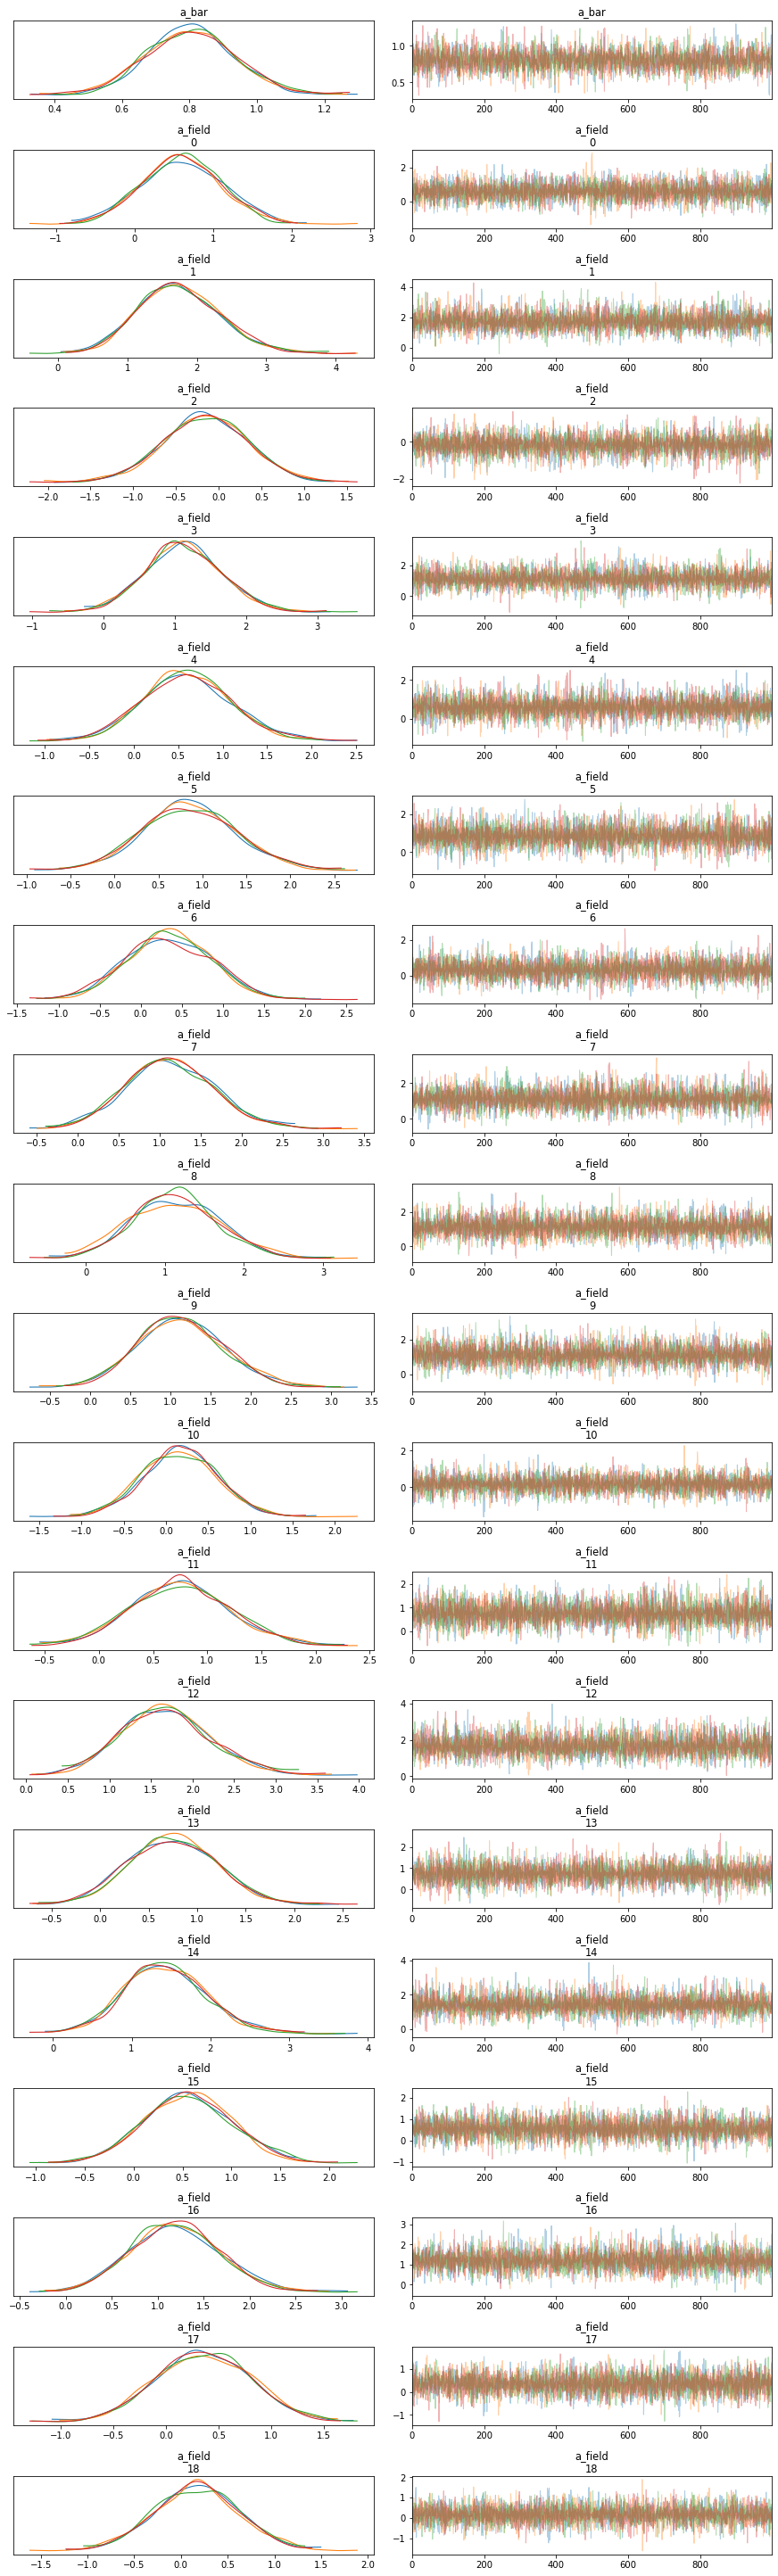

In [53]:
az.plot_trace(m_nopool_trace)

In [54]:
m_nopool_trace['a_field'].mean(0)

array([ 0.59957359,  1.75005895, -0.15579344,  1.12765037,  0.6015724 ,
        0.8560389 ,  0.34709468,  1.13154239,  1.13717691,  1.13260583,
        0.16993995,  0.753429  ,  1.68254367,  0.75063515,  1.42713848,
        0.55517939,  1.19437378,  0.35625158,  0.16780349,  0.35153977,
        1.22177864,  1.03859596,  1.04124415,  0.52547968,  0.3665438 ,
        1.03940232, -0.39824324,  1.03397805,  2.15658361, -1.06958667,
        0.65074045,  0.382385  ,  1.4183701 ,  0.78727076,  1.08526542,
       -0.40312295, -0.39997718,  1.41579165,  1.41305131,  0.25162656,
        0.72727499,  1.57962982, -0.51729641,  1.26702183,  0.72810226,
        1.58081364,  1.41792107,  1.58085224,  0.98842132,  1.94951011])

In [64]:
nopool_pred = m_nopool_pred['crops'].mean(0)

[]

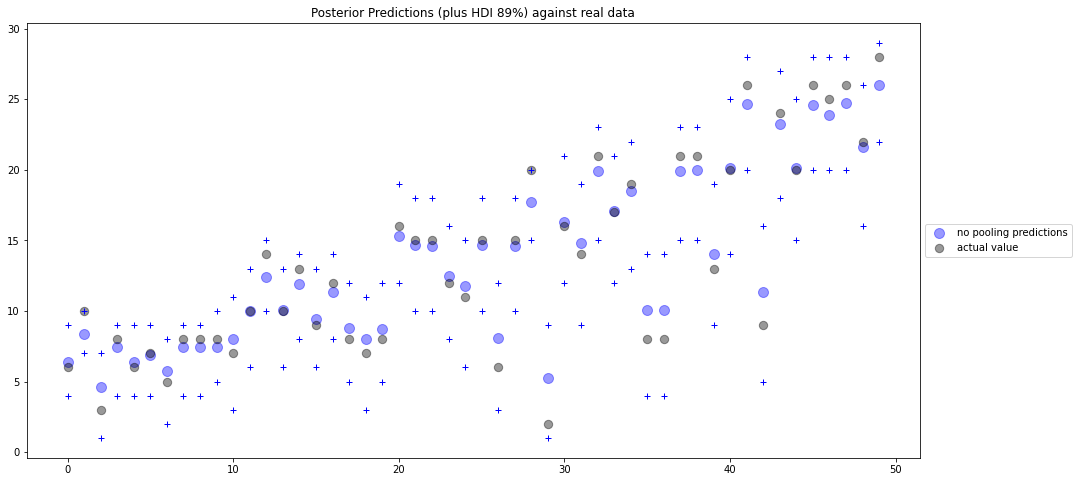

In [77]:
_, ax = plt.subplots(figsize=(16,8))
ax.scatter(field, nopool_pred, c='b', s=100, alpha=0.4, label='no pooling predictions') 
ax.scatter(field, df.crops, c='k', s=70, alpha=0.4, label='actual value') 
ax.plot([range(0, n_fields), range(0, n_fields)], az.hdi(m_nopool_pred['crops'], hdi_prob=0.89).T, 'b+')

plt.title('Posterior Predictions (plus HDI 89%) against real data')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.plot()

In [74]:
range(0, n_fields)

range(0, 50)